# Multi Layer Perceptron from Scratch in TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Creating MLP class

In [2]:
class MLP:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}
        self.b = {}
        
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):
        for i in range(1, self.L):
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])))
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], 1)))
    
    
    def forward_pass(self, A):
        A = tf.convert_to_tensor(A, dtype=tf.float32)
        for i in range(1, self.L):
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            if i != self.L-1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A
    
    
    def compute_loss(self, A, Y):
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y, A))
    
    
    def update_params(self, lr):
        for i in range(1, self.L):
            self.W[i].assign_sub(lr * self.dW[i])
            self.b[i].assign_sub(lr * self.db[i])
            
    def predict(self, X):
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)
    
    def summary(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:\t', self.num_features)
        print('Number of Classes:\t', self.num_classes)
        print('Hidden Layers:')
        print('===================')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('===================')
        print('Number of parameters:', num_params)
        
    
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for key in self.W.keys():
            self.dW[key] = tape.gradient(loss, self.W[key])
            self.db[key] = tape.gradient(loss, self.b[key])
        del tape
        self.update_params(lr)
        
        return loss.numpy()
    
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size, lr):  #  ,  steps_per_epoch, 
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': [],
            'train_acc': []
        }
        steps_per_epoch = int(x_train.shape[0]/batch_size)

        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {0}/{1}\t['.format(e+1, epochs), end='')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/5) == 0:
                    print(end='=')
            print(']', end='')    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            
            val_A = self.forward_pass(x_test)
            history['val_loss'].append(self.compute_loss(val_A, y_test).numpy())
            
            train_preds = self.predict(x_batch)
            history['train_acc'].append(np.mean(np.argmax(y_batch, axis=1) == train_preds.numpy()))
            val_preds = self.predict(x_test)
            history['val_acc'].append(np.mean(np.argmax(y_test, axis=1) == val_preds.numpy()))
            print('\tTrain Acc:', history['train_acc'][-1], end='\t')
            print('Val Acc:', history['val_acc'][-1])
        return history

    def evaluate(self, X, Y):
        preds = self.predict(X)
        return np.mean(np.argmax(Y, axis=1) == preds.numpy())
        # Since we are predicting label as int and in dataset it's OneHotEncoded

## Testing out the MLP class

In [3]:
#  Importing Dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.         # scaling, so tha value lies between (0,1)
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

x_val = x_train[55000:]
x_train = x_train[:55000]
y_val = y_train[55000:]
y_train = y_train[:55000]

print((x_train.shape), (x_val.shape), (x_test.shape))

(55000, 784) (5000, 784) (10000, 784)


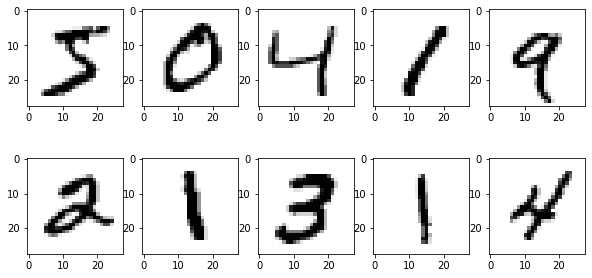

In [4]:
plt.figure(figsize=(10, 5))

for i, index in enumerate(range(10)):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[index].reshape((28, 28)), cmap='binary')

In [5]:
mlp = MLP([784, 128, 128, 10])
mlp.summary()

Input Features:	 784
Number of Classes:	 10
Hidden Layers:
Layer 1, Units 128
Layer 2, Units 128
Number of parameters: 118282


In [6]:
batch_size = 64
epochs = 20
lr = 3e-3

history = mlp.train(x_train, y_train, x_val, y_val, epochs, batch_size, lr)

Epoch 1/20	[======]	Train Acc: 0.765625	Val Acc: 0.8468
Epoch 2/20	[======]	Train Acc: 0.796875	Val Acc: 0.8638
Epoch 3/20	[======]	Train Acc: 0.8125	Val Acc: 0.876
Epoch 4/20	[======]	Train Acc: 0.84375	Val Acc: 0.8756
Epoch 5/20	[======]	Train Acc: 0.859375	Val Acc: 0.8812
Epoch 6/20	[======]	Train Acc: 0.859375	Val Acc: 0.8814
Epoch 7/20	[======]	Train Acc: 0.875	Val Acc: 0.89
Epoch 8/20	[======]	Train Acc: 0.875	Val Acc: 0.8884
Epoch 9/20	[======]	Train Acc: 0.875	Val Acc: 0.8884
Epoch 10/20	[======]	Train Acc: 0.890625	Val Acc: 0.8904
Epoch 11/20	[======]	Train Acc: 0.890625	Val Acc: 0.8856
Epoch 12/20	[======]	Train Acc: 0.90625	Val Acc: 0.8818
Epoch 13/20	[======]	Train Acc: 0.890625	Val Acc: 0.8832
Epoch 14/20	[======]	Train Acc: 0.90625	Val Acc: 0.88
Epoch 15/20	[======]	Train Acc: 0.890625	Val Acc: 0.8834
Epoch 16/20	[======]	Train Acc: 0.90625	Val Acc: 0.9002
Epoch 17/20	[======]	Train Acc: 0.890625	Val Acc: 0.8958
Epoch 18/20	[======]	Train Acc: 0.890625	Val Acc: 0.8934
Epo

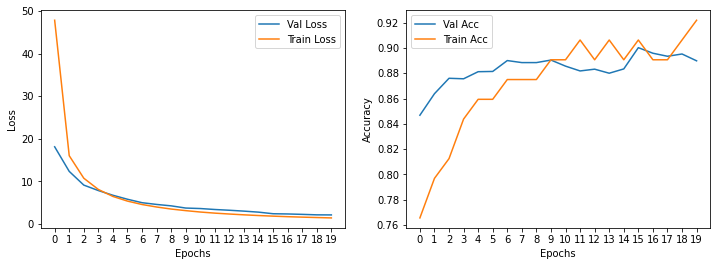

In [7]:
#Plotting Training-Validation accuracies and loss.

plt.figure(figsize=(12, 4))
epochs = len(history['val_loss'])
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history['val_loss'], label='Val Loss')
plt.plot(range(epochs), history['train_loss'], label='Train Loss')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(epochs), history['val_acc'], label='Val Acc')
plt.plot(range(epochs), history['train_acc'], label='Train Acc')
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
test_accuracy = mlp.evaluate(x_test, y_test)

In [9]:
print('Test Accuracy : ', test_accuracy)

Test Accuracy :  0.8723
